In [ ]:
#instal dependies
!pip install kaggle

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 71 bytes


In [ ]:
!kaggle competitons list

usage: kaggle [-h] [-v] {competitions,c,datasets,d,kernels,k,config} ...
kaggle: error: argument command: invalid choice: 'competitons' (choose from 'competitions', 'c', 'datasets', 'd', 'kernels', 'k', 'config')


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia --force

 99% 2.28G/2.29G [00:29<00:00, 44.6MB/s]
100% 2.29G/2.29G [00:29<00:00, 83.3MB/s]


In [ ]:
from zipfile import ZipFile
file_name = "chest-xray-pneumonia.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
train_path = '/content/chest_xray/chest_xray/train'


In [ ]:
#rescale = 1/.255
test_path = '/content/chest_xray/chest_xray/test'
valid_path = '/content/chest_xray/chest_xray/val'

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [ ]:
train_path = '/content/chest_xray/chest_xray/train'

In [ ]:
#rescale = 1/.255
test_path = '/content/chest_xray/chest_xray/test'
valid_path = '/content/chest_xray/chest_xray/val'

In [ ]:
train_datagen = ImageDataGenerator(    
                                       rotation_range=360,
                                       width_shift_range=0.05,
                                       height_shift_range=0.05,
                                       shear_range=0.10,
                                       zoom_range=0.3,
                                    
                                       horizontal_flip=True,
                                       vertical_flip=True)

In [ ]:
test_datagen = ImageDataGenerator()

In [ ]:
train_batches = train_datagen.flow_from_directory(directory=train_path, target_size=(224,224),
    classes=['NORMAL', 'PNEUMONIA'], batch_size=32, shuffle = True)
valid_batches = ImageDataGenerator().flow_from_directory(directory=valid_path, target_size=(224,224),
    classes=['NORMAL', 'PNEUMONIA'], batch_size=4)
test_batches = test_datagen.flow_from_directory(directory=test_path, target_size=(224,224),
    classes=['NORMAL', 'PNEUMONIA'], batch_size=16,shuffle=True)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(30,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [ ]:
imgs, labels = next(train_batches)

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


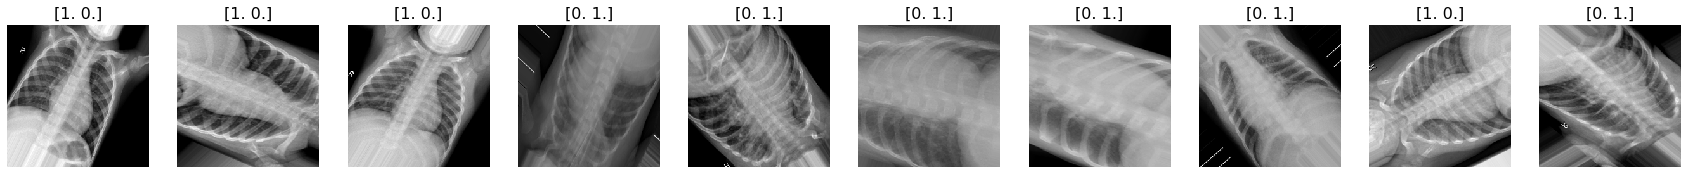

In [ ]:
plots(imgs, titles=labels)

In [ ]:
imgs1, labels1 = next(test_batches)

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


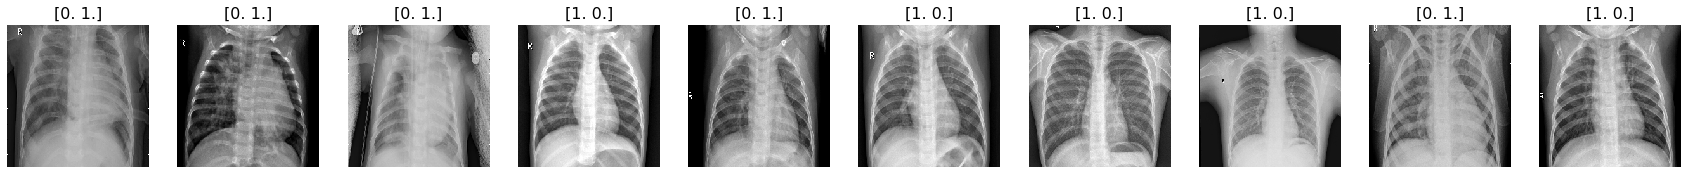

In [ ]:
plots(imgs1,titles=labels1)

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import L1L2

In [ ]:
train_batches

In [ ]:
!pip install tensorflow==2.3.0

In [ ]:
#!pip install --upgrade tensorflow

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras import backend as K
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3),kernel_regularizer=l2(0.1), 
                 activation='relu' ,padding='same', 
                 name='conv_1', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2), name = 'maxpool_1'))
model.add(Dropout(0.6))
model.add(Flatten())
model.add(Dense(128, activation='relu', name='dense_1'))
model.add(Dense(64, activation='relu', name='dense_2'))
model.add(Dense(2, activation='softmax', name='output'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 112, 112, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 401408)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               51380352  
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
output (Dense)               (None, 2)                 1

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1)
model.compile(optimizer=keras.optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
hist = model.fit_generator(generator=train_batches, validation_data=test_batches, epochs= 10, verbose=2)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
163/163 - 98s - loss: 157.7746 - accuracy: 0.6346 - val_loss: 68.9284 - val_accuracy: 0.3750
Epoch 2/10
163/163 - 98s - loss: 58.1581 - accuracy: 0.6457 - val_loss: 129.0004 - val_accuracy: 0.6250
Epoch 3/10
163/163 - 97s - loss: 36.9072 - accuracy: 0.7285 - val_loss: 72.9170 - val_accuracy: 0.6250
Epoch 4/10
163/163 - 97s - loss: 31.9890 - accuracy: 0.7483 - val_loss: 15.5095 - val_accuracy: 0.7660
Epoch 5/10
163/163 - 98s - loss: 19.2932 - accuracy: 0.7874 - val_loss: 7.0573 - val_accuracy: 0.8766
Epoch 6/10
163/163 - 97s - loss: 7.4891 - accuracy: 0.8347 - val_loss: 9.8304 - val_accuracy: 0.8349
Epoch 7/10
163/163 - 98s - loss: 8.2178 - accuracy: 0.8345 - val_loss: 6.4867 - val_accuracy: 0.8574
Epoch 8/10
163/163 - 98s - loss: 9.4475 - accuracy: 0.8263 - val_loss: 7.0236 - val_accuracy: 0.8638
Epoch 9/10
163/163 - 98s - loss: 6.7466 - accuracy: 0.8363 - val_loss: 6.9954 - val_accuracy: 0.8510
Epoc

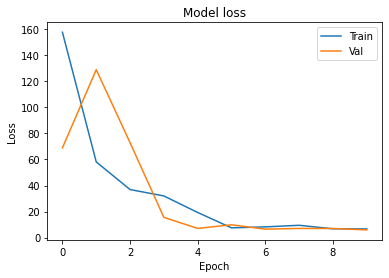

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

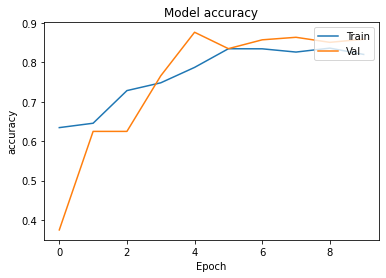

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [ ]:
IMAGE_SIZE = [224, 224]

In [ ]:
train_path = '/content/chest_xray/chest_xray/train'

In [ ]:
test_path = '/content/chest_xray/chest_xray/test'
valid_path = '/content/chest_xray/chest_xray/val'

In [ ]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [ ]:
# useful for getting number of classes
folders = glob('/content/chest_xray/chest_xray/train/*')

In [ ]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [ ]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [ ]:
# view the structure of the model
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory('/content/chest_xray/chest_xray/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 5216 images belonging to 2 classes.


In [ ]:
test_set = test_datagen.flow_from_directory('/content/chest_xray/chest_xray/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 624 images belonging to 2 classes.


In [ ]:
'''r=model.fit_generator(training_set,
                         samples_per_epoch = 8000,
                         nb_epoch = 10,
                         validation_data = test_set,
                         nb_val_samples = 2000)'''

'r=model.fit_generator(training_set,\n                         samples_per_epoch = 8000,\n                         nb_epoch = 10,\n                         validation_data = test_set,\n                         nb_val_samples = 2000)'

In [ ]:
# fit the model
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs= 5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
163/163 [==============================] - 112s 687ms/step - loss: 0.1968 - accuracy: 0.9218 - val_loss: 0.2485 - val_accuracy: 0.9167
Epoch 2/5
163/163 [==============================] - 109s 672ms/step - loss: 0.1222 - accuracy: 0.9540 - val_loss: 0.2228 - val_accuracy: 0.9135
Epoch 3/5
163/163 [==============================] - 113s 690ms/step - loss: 0.0944 - accuracy: 0.9649 - val_loss: 0.3194 - val_accuracy: 0.9119
Epoch 4/5
163/163 [==============================] - 112s 690ms/step - loss: 0.0955 - accuracy: 0.9634 - val_loss: 0.5677 - val_accuracy: 0.8670
Epoch 5/5
163/163 [==============================] - 112s 685ms/step - loss: 0.0855 - accuracy: 0.9676 - val_loss: 0.2975 - val_accuracy: 0.9119


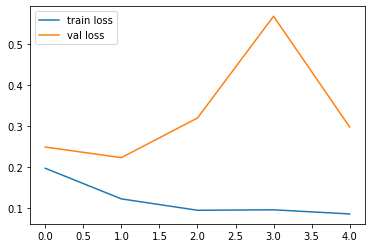

In [ ]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

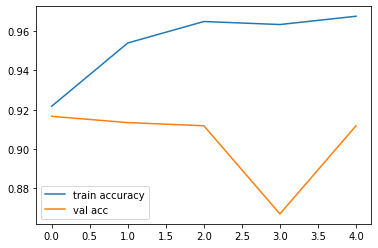

In [ ]:
# accuracies
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
